In [57]:
#Importing necessary libraries:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from scipy.sparse import issparse
import bbknn
import numpy as np
import scanpy.external as sce
import phate
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib.colors import to_hex


In [58]:
#Loading count matrices
wt_counts = pd.read_csv('/data/BIOL5177/Assessment/WT1/counts_matrix.csv', index_col=0)
inf1_counts = pd.read_csv('/data/BIOL5177/Assessment/Infected1/counts_matrix.csv', index_col=0)
inf2_counts = pd.read_csv('/data/BIOL5177/Assessment/Infected2/counts_matrix.csv', index_col=0)

#Loading metadata
wt_metadata = pd.read_csv('/data/BIOL5177/Assessment/WT1/metadata.csv', index_col=0)
inf1_metadata = pd.read_csv('/data/BIOL5177/Assessment/Infected1/metadata.csv', index_col=0)
inf2_metadata = pd.read_csv('/data/BIOL5177/Assessment/Infected2/metadata.csv', index_col=0)

#Transposing the counts matrices and creating the AnnData objects:
wt_counts = wt_counts.T
inf1_counts = inf1_counts.T
inf2_counts = inf2_counts.T

#Creating AnnData Objects:
wt = sc.AnnData(wt_counts)  
inf1 = sc.AnnData(inf1_counts)  
inf2 = sc.AnnData(inf2_counts)  

#Setting var names as gene names
wt.var_names = wt_counts.columns
inf1.var_names = inf1_counts.columns
inf2.var_names = inf2_counts.columns

#Assigning the metadata to the AnnData objects
wt.obs = wt_metadata
inf1.obs = inf1_metadata
inf2.obs = inf2_metadata

#Adding condition
wt.obs['condition'] = 'WT'
inf1.obs['condition'] = 'Infected1'
inf2.obs['condition'] = 'Infected2'

#Verifying:
print(wt.obs.head())
print(inf1.obs.head())
print(inf2.obs.head())

                       orig.ident  nCount_RNA  nFeature_RNA condition
CTCACTGCAGCTACTA_6  SeuratProject        3547          1528        WT
TGTGCGGTCCTGCTAC_6  SeuratProject        3655          1388        WT
ACTTAGGTCAGACATC_6  SeuratProject        4724          1903        WT
ACCTGAACAAATCGGG_6  SeuratProject       16599          2030        WT
AAGATAGAGCCTCGTG_6  SeuratProject       15527          3702        WT
                       orig.ident  nCount_RNA  nFeature_RNA  condition
AATAGAGCAGGAGACT_4  SeuratProject       32115          5339  Infected1
TTCCGGTCACAGAAGC_4  SeuratProject       24284          4996  Infected1
GGGTCACAGTTAGTAG_4  SeuratProject       26603          4837  Infected1
ATGGAGGTCGACCAAT_4  SeuratProject       19089          2843  Infected1
TTCCTAACACGCTGCA_4  SeuratProject       13837          2471  Infected1
                       orig.ident  nCount_RNA  nFeature_RNA  condition
AAACGCTAGAGTGAAG_5  SeuratProject        4684          1965  Infected2
AACAAAGAGTGA

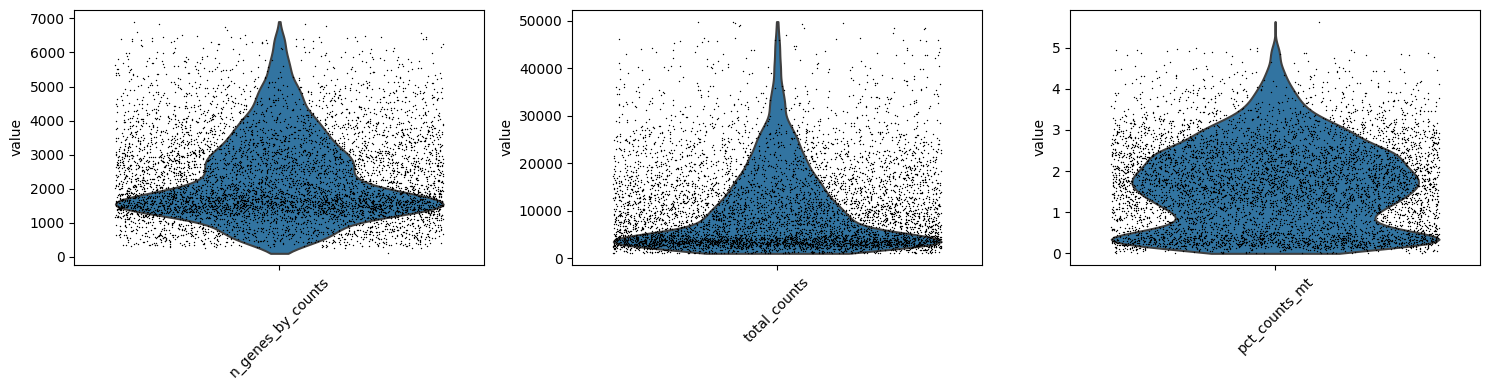

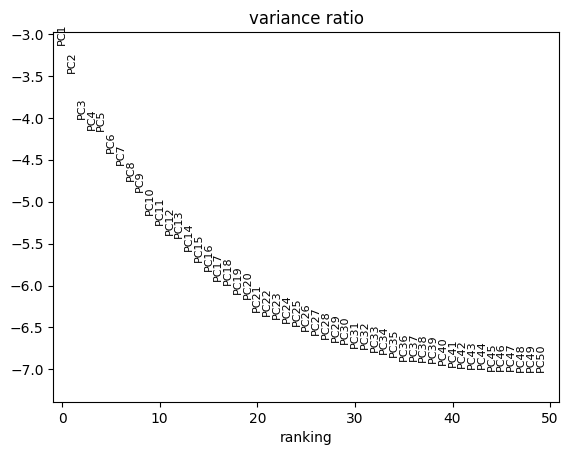

In [60]:
#Task 2a- Perform the standard ScanPy analysis pipeline:

#Concatenating datasets without creating unnecessary copies
adata = sc.concat([wt, inf1, inf2], label='sample', keys=['WT1', 'Infected1', 'Infected2'])

#Ensuring gene names are strings
adata.var_names = adata.var_names.astype(str)

#Identifying mitochondrial genes (gene names starting with "MT-")
adata.var['mt'] = adata.var_names.str.upper().str.startswith('MT-')

#Calculating QC metrics
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

#Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

#Plotting Number of genes per cell
sc.pl.violin(
    adata,
    keys='n_genes_by_counts',
    jitter=0.4,
    stripplot=True,       
    rotation=45,
    ax=axes[0],
    show=False
)

#Plotting Total counts per cell
sc.pl.violin(
    adata,
    keys='total_counts',
    jitter=0.4,
    stripplot=True,       
    rotation=45,
    ax=axes[1],
    show=False
)

#Plotting mitochondrial counts
sc.pl.violin(
    adata,
    keys='pct_counts_mt',
    jitter=0.4,
    stripplot=True,       
    rotation=45,
    ax=axes[2],
    show=False
)

plt.tight_layout()
plt.show()

#Filtering cells for doublets and singlets and maintaining overall quality
adata = adata[adata.obs.n_genes_by_counts > 200, :]
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[adata.obs.total_counts > 500, :]
adata = adata[adata.obs.total_counts < 40000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

#Saving raw counts 
adata.layers["raw_counts"] = adata.X.copy()

#Normalizing total counts per cell to 10,000
sc.pp.normalize_total(adata, target_sum=1e4)

#Log-transforming the normalized data
sc.pp.log1p(adata)

#Saving log-normalized values
adata.layers["log_norm"] = adata.X.copy()

#Identifying highly variable genes (HVGs) 
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

#Scaling the data
sc.pp.scale(adata, max_value=10)

#Running PCA
sc.tl.pca(adata, svd_solver='arpack', random_state=43)

#Visualizing variance explained to decide the number of PCs
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)


/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


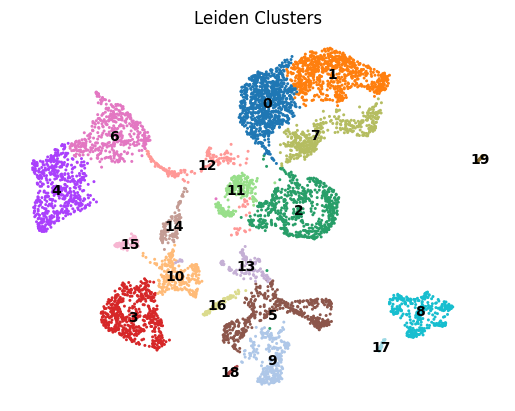

/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


0     898
1     769
2     632
3     559
4     548
5     474
6     457
7     415
8     326
9     290
10    258
11    202
12    184
13    131
14    117
15     80
16     73
17     31
18     29
19     25
Name: leiden, dtype: int64


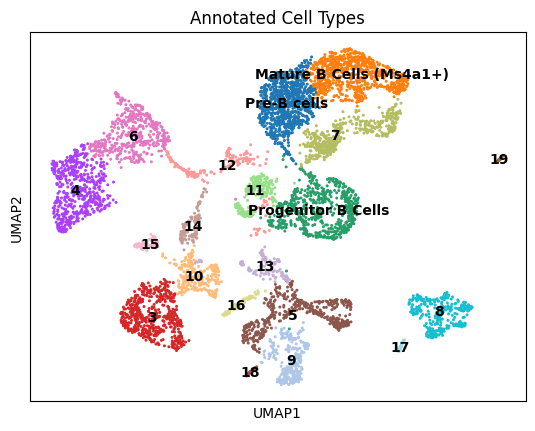

/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.st

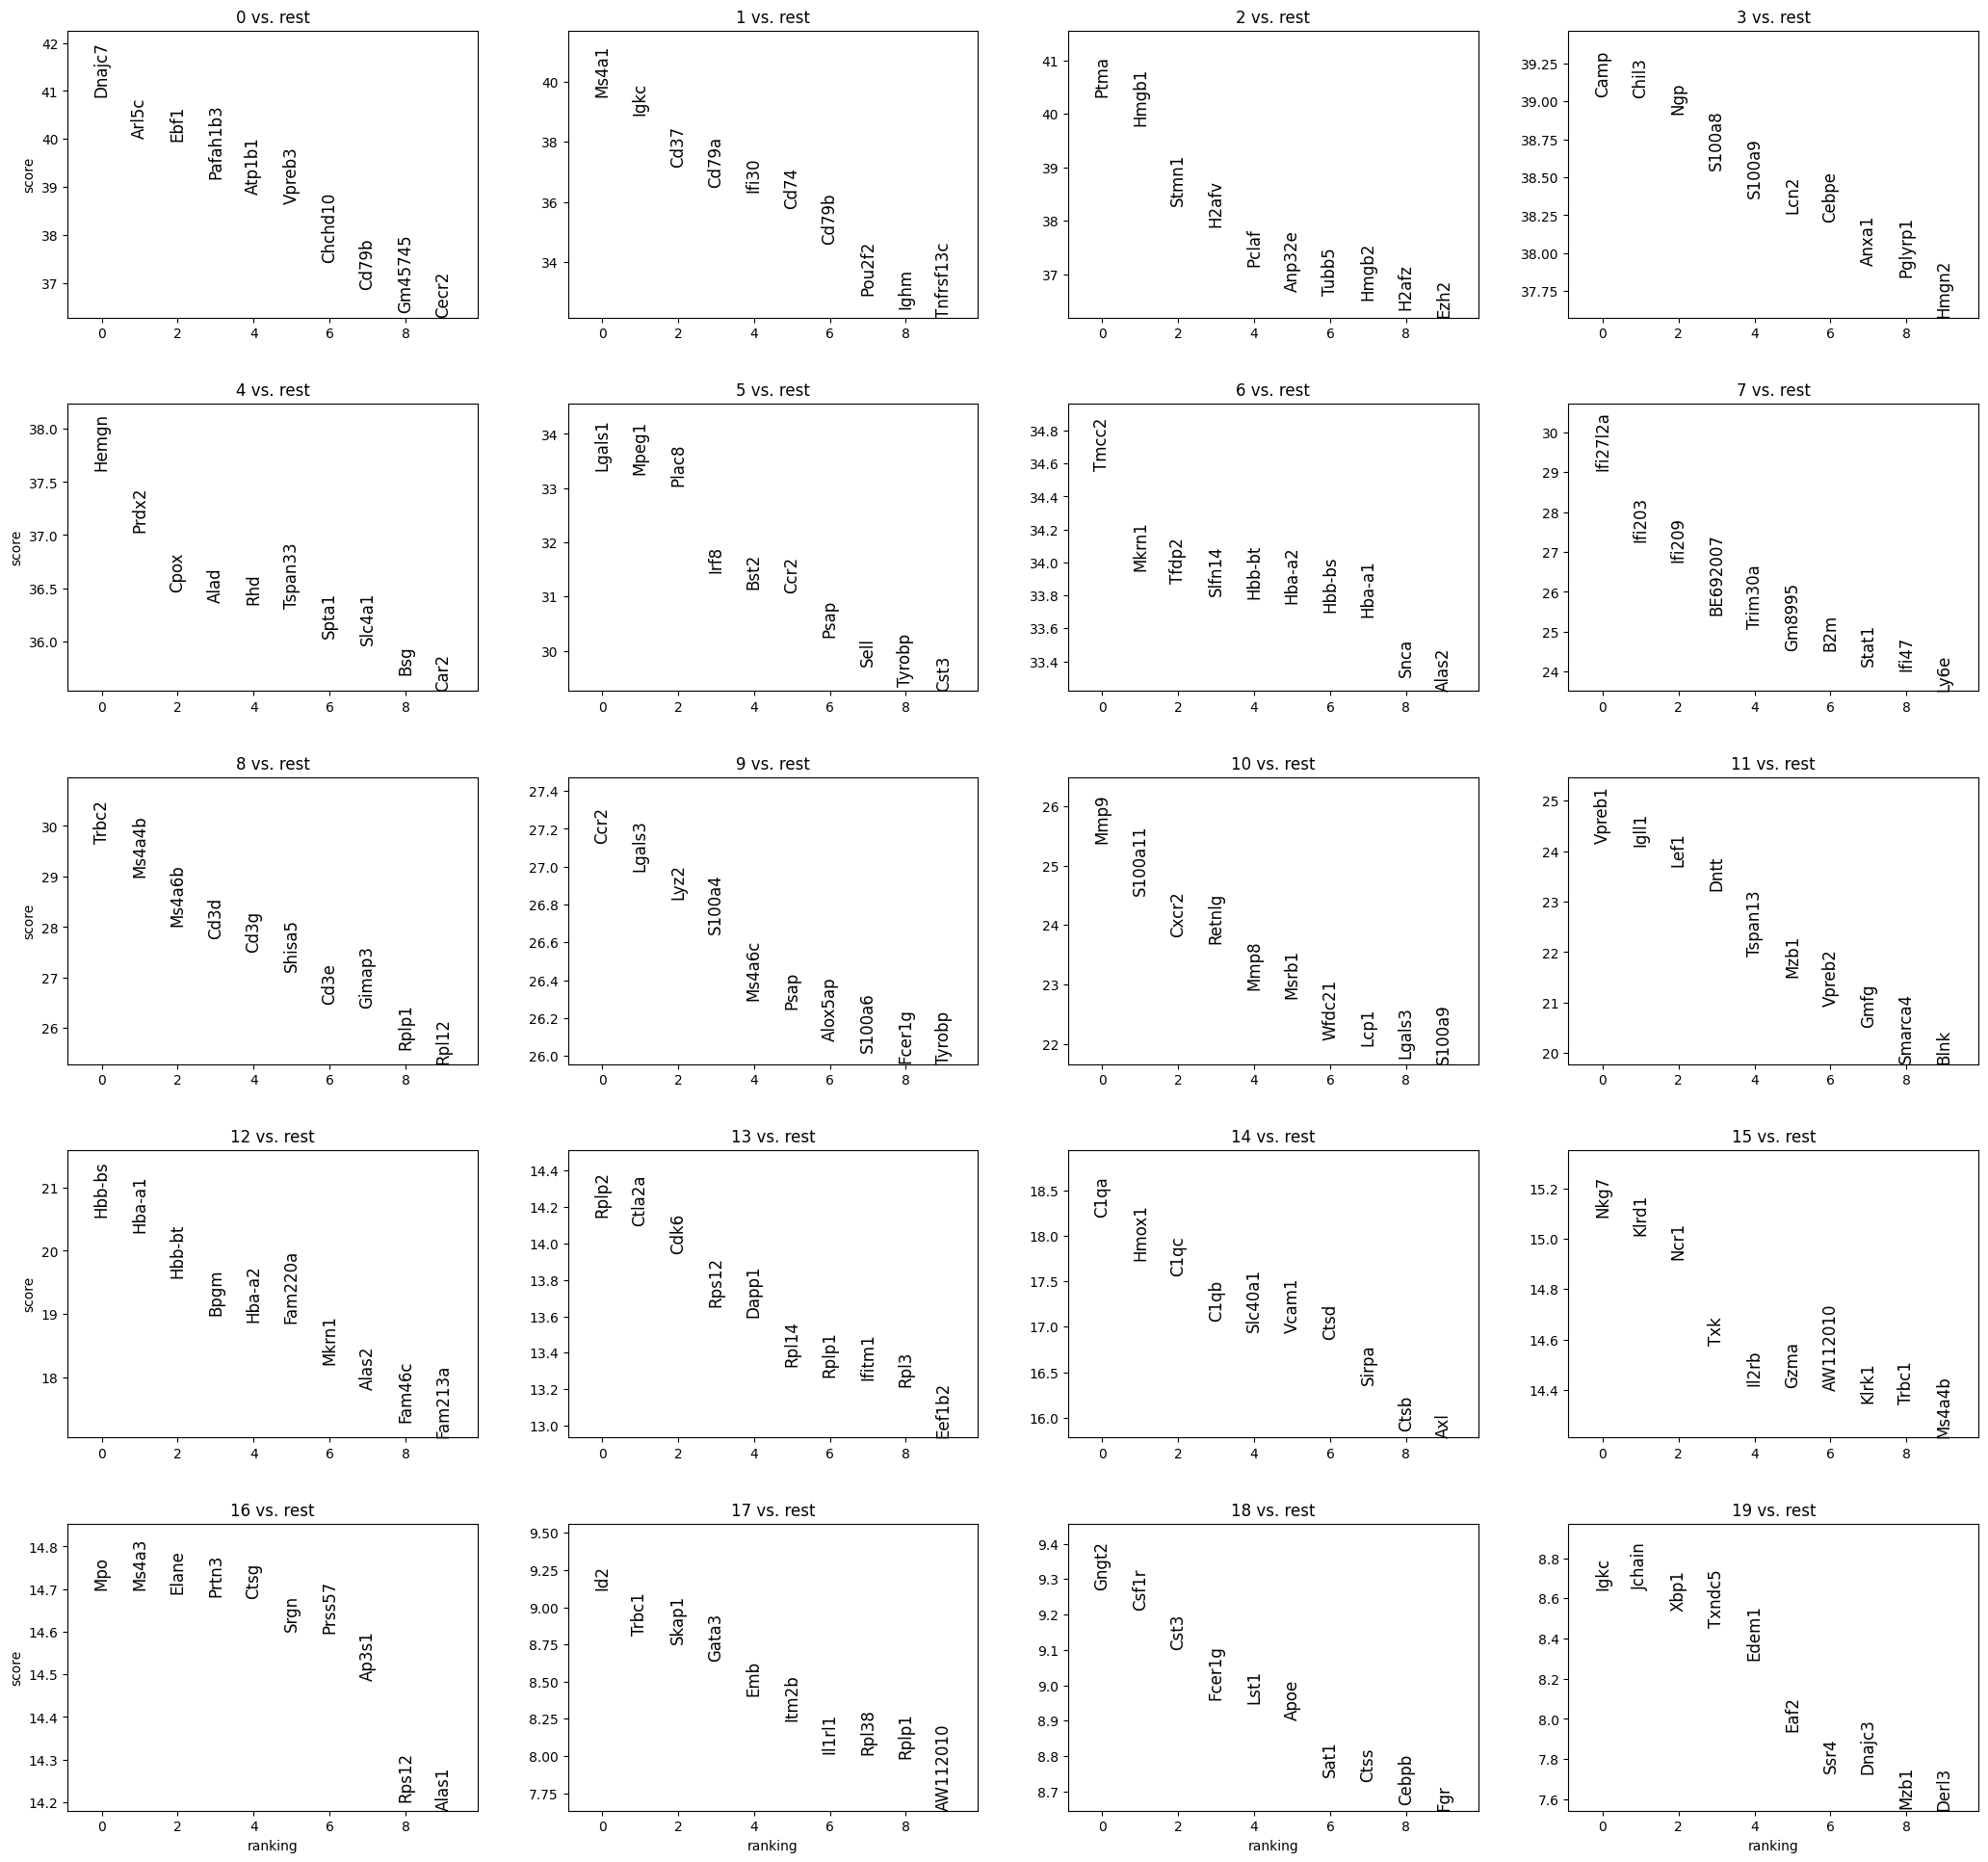

In [61]:
#Task 2b- Clustering the data and annotating the three largest clusters:
adata_2b = adata.copy()

#Running PCA 
sc.tl.pca(adata_2b, svd_solver='arpack')

# Clustering the data
sc.pp.neighbors(adata_2b, n_neighbors=15, n_pcs=30)
sc.tl.leiden(adata_2b, resolution=0.4)

#Saving the clusters
adata_2b.obs['leiden_Scanpy'] = adata_2b.obs['leiden']

#Creating UMAP
sc.tl.umap(adata_2b)
sc.pl.umap(adata_2b, color='leiden_Scanpy', legend_loc='on data', title='Leiden Clusters', frameon=False)

#Annotating the top 3 clusters
print(adata_2b.obs['leiden'].value_counts())
adata_2b.obs['celltype'] = adata_2b.obs['leiden_Scanpy'].replace({
    '0': 'Pre-B cells',
    '1': 'Mature B Cells (Ms4a1+)',
    '2': 'Progenitor B Cells'
})
sc.pl.umap(adata_2b, color='celltype', legend_loc='on data', title='Annotated Cell Types')

#Identifying and visualize top genes per cluster
sc.tl.rank_genes_groups(adata_2b, groupby='leiden_Scanpy', method='wilcoxon')
sc.pl.rank_genes_groups(adata_2b, n_genes=10, sharey=False, fontsize=12)

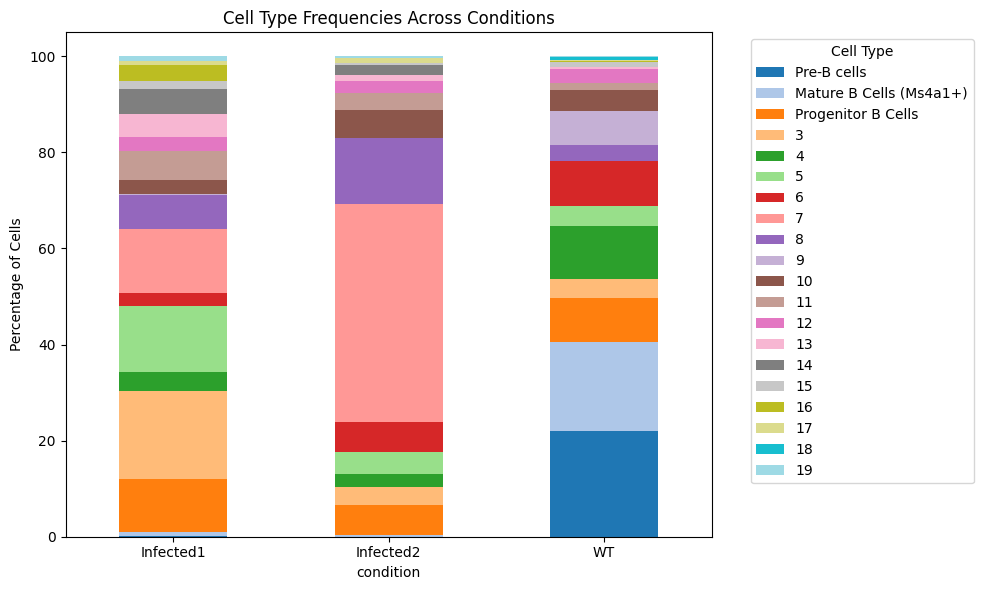

In [62]:
#Task 2c: Plotting the frequency of cell types in the clusters to allow frequency comparison:

# Group by celltype and condition to get raw counts
freq_counts = adata_2b.obs.groupby(['celltype', 'condition']).size().unstack(fill_value=0)

# Convert to percentage within each condition
freq_percent = freq_counts.div(freq_counts.sum(axis=0), axis=1) * 100

# Generate a color palette with as many colors as there are cell types
cell_types = freq_percent.index.tolist()
colors = sns.color_palette('tab20', n_colors=len(cell_types))  # or use 'hls', 'Paired', 'Set3', etc.

# Plotting frequency of cell types with custom colors
ax = freq_percent.T.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

plt.ylabel('Percentage of Cells')
plt.title('Cell Type Frequencies Across Conditions')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cell Type')
plt.tight_layout()
plt.show()


[BBKNN] Min expression value of Ms4a1: -0.4596669375896454
[BBKNN] Max expression value of Ms4a1: 3.729680061340332
[BBKNN] Ms4a1-enriched cluster: 1
[BBKNN] Number of cells in Ms4a1-enriched cluster: 841


/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


[BBKNN] Found 224 upregulated genes in infected vs WT B cells.
         gene     logfc      pval_adj       comparison
11   BE692007  4.567450  4.890866e-24  Infected1_vs_WT
14       Ly6e  3.082741  1.431892e-22  Infected1_vs_WT
20      Psme1  4.313810  2.713060e-16  Infected1_vs_WT
23     Shisa5  4.372468  4.559556e-16  Infected1_vs_WT
26     Samhd1  3.222134  9.725317e-16  Infected1_vs_WT
28      Sp100  3.970888  5.374134e-15  Infected1_vs_WT
40       Ly86  3.758186  1.027524e-12  Infected1_vs_WT
46      Sp110  6.117673  3.240558e-11  Infected1_vs_WT
47      Zufsp  7.219164  6.197312e-11  Infected1_vs_WT
49      Rplp2  1.989278  1.863947e-10  Infected1_vs_WT
52    Selenow  3.372162  3.164409e-09  Infected1_vs_WT
56      Rps12  1.264338  5.676085e-09  Infected1_vs_WT
59  Rps24-ps3  2.325353  1.156856e-08  Infected1_vs_WT
62     Smchd1  4.709170  3.892922e-08  Infected1_vs_WT
63     Clec2d  5.097573  3.946618e-08  Infected1_vs_WT
64       Tpt1  1.062346  3.946618e-08  Infected1_vs_WT
65

/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


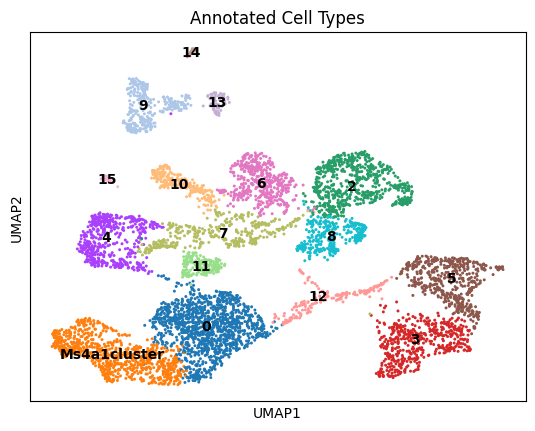

In [63]:
#Task2d- DE analysis on BBKNN integrated data:

#Making a copy of adata for BBKNN integration
adata_bbknn = adata.copy()

#BBKNN integration
bbknn.bbknn(adata_bbknn, batch_key='condition', n_pcs=30)

#Computing the UMAP and Leiden clustering on BBKNN integrated data
sc.tl.umap(adata_bbknn)
sc.tl.leiden(adata_bbknn, resolution=0.4, random_state=43)
adata_bbknn.obs['leiden_BBKNN'] = adata_bbknn.obs['leiden']

#Saving raw counts for pseudobulk DE
adata_bbknn.raw = adata_bbknn

#Ms4a1 cluster detection
ms4a1_expr_bb = adata_bbknn[:, 'Ms4a1'].X.toarray().flatten()
print(f"[BBKNN] Min expression value of Ms4a1: {np.min(ms4a1_expr_bb)}")
print(f"[BBKNN] Max expression value of Ms4a1: {np.max(ms4a1_expr_bb)}")

ms4a1_cluster_bb = adata_bbknn.obs['leiden_BBKNN'][ms4a1_expr_bb > np.percentile(ms4a1_expr_bb, 90)].mode()[0]
print(f"[BBKNN] Ms4a1-enriched cluster: {ms4a1_cluster_bb}")

ms4a1_cells_bb = adata_bbknn[adata_bbknn.obs['leiden_BBKNN'] == ms4a1_cluster_bb]
print(f"[BBKNN] Number of cells in Ms4a1-enriched cluster: {ms4a1_cells_bb.shape[0]}")

ms4a1_cells_bb.X = ms4a1_cells_bb.layers["log_norm"]

#Differential Expression Analysis
infected_groups = [x for x in ms4a1_cells_bb.obs['condition'].unique() if 'Infected' in x]
all_results_bb = []

#Iterating over the data and performing DE between cells of different conditions on given filtering thresholds:
for group in infected_groups:
    sc.tl.rank_genes_groups(ms4a1_cells_bb, groupby='condition', method='wilcoxon', reference='WT', groups=[group])
    de_bb = ms4a1_cells_bb.uns['rank_genes_groups']
    df = pd.DataFrame({
        'gene': de_bb['names'][group],
        'logfc': de_bb['logfoldchanges'][group],
        'pval_adj': de_bb['pvals_adj'][group],
        'comparison': f"{group}_vs_WT"
    })
    all_results_bb.append(df)

combined_bb = pd.concat(all_results_bb)
up_genes_bb = combined_bb[(combined_bb['logfc'] > 0.5) & (combined_bb['pval_adj'] < 0.01)]

print(f"[BBKNN] Found {len(up_genes_bb)} upregulated genes in infected vs WT B cells.")
print(up_genes_bb.head(20))

#Visualising clusters post BBKNN integration
print(adata_bbknn.obs['leiden_BBKNN'].value_counts())
adata_bbknn.obs['celltype'] = adata_bbknn.obs['leiden_BBKNN'].replace({
    '1': 'Ms4a1cluster',
})
sc.pl.umap(adata_bbknn, color='celltype', legend_loc='on data', title='Annotated Cell Types')

2025-04-07 04:21:00,673 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-07 04:21:02,954 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-07 04:21:02,984 - harmonypy - INFO - Iteration 1 of 10
2025-04-07 04:21:03,964 - harmonypy - INFO - Iteration 2 of 10
2025-04-07 04:21:04,836 - harmonypy - INFO - Iteration 3 of 10
2025-04-07 04:21:05,691 - harmonypy - INFO - Iteration 4 of 10
2025-04-07 04:21:06,550 - harmonypy - INFO - Iteration 5 of 10
2025-04-07 04:21:07,245 - harmonypy - INFO - Iteration 6 of 10
2025-04-07 04:21:07,788 - harmonypy - INFO - Iteration 7 of 10
2025-04-07 04:21:08,189 - harmonypy - INFO - Converged after 7 iterations


[Harmony] Min expression value of Ms4a1: -0.4596669375896454
[Harmony] Max expression value of Ms4a1: 3.729680061340332
[Harmony] Ms4a1-enriched cluster: 1
[Harmony] Number of cells in Ms4a1-enriched cluster: 949


/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


[Harmony] Found 220 upregulated genes in infected vs WT B cells.
              gene     logfc      pval_adj       comparison
11        BE692007  4.926146  3.099190e-30  Infected1_vs_WT
13            Ly6e  3.117072  1.263127e-27  Infected1_vs_WT
20           Psme1  4.899890  4.163999e-22  Infected1_vs_WT
21           Sp100  4.372820  5.864091e-22  Infected1_vs_WT
32          Samhd1  3.218770  1.145102e-17  Infected1_vs_WT
41         Selenow  3.764419  7.537201e-15  Infected1_vs_WT
43            Ly86  3.928514  9.286033e-15  Infected1_vs_WT
53          Shisa5  4.585884  3.813797e-12  Infected1_vs_WT
55            Tpt1  1.074027  4.727225e-12  Infected1_vs_WT
57         mt-Rnr2  1.060846  1.790448e-11  Infected1_vs_WT
59           Zufsp  8.557694  5.384745e-11  Infected1_vs_WT
60          Clec2d  8.116413  1.035104e-10  Infected1_vs_WT
64          Samd9l  2.316891  1.255387e-10  Infected1_vs_WT
68           Rplp2  1.925377  4.445928e-10  Infected1_vs_WT
70         mt-Rnr1  2.320959  4.478

/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


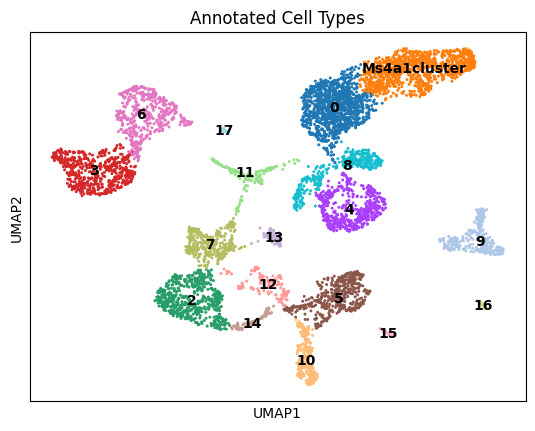

In [64]:
#Task2e- DE analysis on BBKNN integrated data:

#Making a copy of adata for Harmony integration
adata_harmony = adata.copy()

#Harmony integration
adata_harmony.obsm["X_pca_harmony_input"] = adata_harmony.obsm["X_pca"][:, :30]
sce.pp.harmony_integrate(adata_harmony, key='condition', basis='X_pca_harmony_input', adjusted_basis='X_pca_harmony')

# Computing UMAP and Leiden clustering on Harmony integrated data
sc.pp.neighbors(adata_harmony, n_neighbors=15, n_pcs=30, use_rep='X_pca_harmony', random_state=43)
sc.tl.umap(adata_harmony)
sc.tl.leiden(adata_harmony, resolution=0.4, random_state=43)
adata_harmony.obs['leiden_Harmony'] = adata_harmony.obs['leiden']

#Saving raw counts for pseudobulk DE
adata_harmony.raw = adata_harmony

#Ms4a1 cluster detection
ms4a1_expr_hm = adata_harmony[:, 'Ms4a1'].X.toarray().flatten()
print(f"[Harmony] Min expression value of Ms4a1: {np.min(ms4a1_expr_hm)}")
print(f"[Harmony] Max expression value of Ms4a1: {np.max(ms4a1_expr_hm)}")

ms4a1_cluster_hm = adata_harmony.obs['leiden_Harmony'][ms4a1_expr_hm > np.percentile(ms4a1_expr_hm, 90)].mode()[0]
print(f"[Harmony] Ms4a1-enriched cluster: {ms4a1_cluster_hm}")

ms4a1_cells_hm = adata_harmony[adata_harmony.obs['leiden_Harmony'] == ms4a1_cluster_hm]
print(f"[Harmony] Number of cells in Ms4a1-enriched cluster: {ms4a1_cells_hm.shape[0]}")

ms4a1_cells_hm.X = ms4a1_cells_hm.layers["log_norm"]

#Differential Expression Analysis
infected_groups = [x for x in ms4a1_cells_hm.obs['condition'].unique() if 'Infected' in x]
all_results_hm = []

#Iterating over the data and performing DE between cells of different conditions on given filtering thresholds:
for group in infected_groups:
    sc.tl.rank_genes_groups(ms4a1_cells_hm, groupby='condition', method='wilcoxon', reference='WT', groups=[group])
    de_hm = ms4a1_cells_hm.uns['rank_genes_groups']
    df = pd.DataFrame({
        'gene': de_hm['names'][group],
        'logfc': de_hm['logfoldchanges'][group],
        'pval_adj': de_hm['pvals_adj'][group],
        'comparison': f"{group}_vs_WT"
    })
    all_results_hm.append(df)

combined_hm = pd.concat(all_results_hm)
up_genes_hm = combined_hm[(combined_hm['logfc'] > 0.5) & (combined_hm['pval_adj'] < 0.01)]

print(f"[Harmony] Found {len(up_genes_hm)} upregulated genes in infected vs WT B cells.")
print(up_genes_hm.head(20))

#Visualising clusters post Harmony integration
print(adata_harmony.obs['leiden_Harmony'].value_counts())
adata_harmony.obs['celltype'] = adata_harmony.obs['leiden_Harmony'].replace({
    '1': 'Ms4a1cluster',
})
sc.pl.umap(adata_harmony, color='celltype', legend_loc='on data', title='Annotated Cell Types')

In [65]:
#Task2f- Pseudobulk DE Analysis on harmony and BKNN integrated data:

#Subsetting B cells from identified Ms4a1 clusters from BBkNN and Harmony integration
b_cells_bk = adata_bbknn[adata_bbknn.obs['leiden_BBKNN'] == ms4a1_cluster_bb]
b_cells_hm = adata_harmony[adata_harmony.obs['leiden_Harmony'] == ms4a1_cluster_hm]

#Generating raw count pseudobulk matrices
bk_pseudobulk = {}
hm_pseudobulk = {}

for sample in adata.obs['condition'].unique():
    #BBKNN pseudobulk
    if sample in b_cells_bk.obs['condition'].unique():
        bk_layer = b_cells_bk[b_cells_bk.obs['condition'] == sample].layers['raw_counts']
        bk_pseudobulk[sample] = bk_layer.sum(axis=0).toarray().flatten()

    #Harmony pseudobulk
    if sample in b_cells_hm.obs['condition'].unique():
        hm_layer = b_cells_hm[b_cells_hm.obs['condition'] == sample].layers['raw_counts']
        hm_pseudobulk[sample] = hm_layer.sum(axis=0).toarray().flatten()

#Converting to DataFrames for DESeq2
bk_counts_df = pd.DataFrame(bk_pseudobulk, index=b_cells_bk.var_names).astype(int)
hm_counts_df = pd.DataFrame(hm_pseudobulk, index=b_cells_hm.var_names).astype(int)

#Checking for negative values in the counts DataFrames
if (bk_counts_df < 0).any().any():
    print("Warning: Negative values found in BBKNN pseudobulk counts. Correcting...")
    bk_counts_df = bk_counts_df.clip(lower=0)

if (hm_counts_df < 0).any().any():
    print("Warning: Negative values found in Harmony pseudobulk counts. Correcting...")
    hm_counts_df = hm_counts_df.clip(lower=0)

#Creating metadata 
condition_labels = ['WT' if 'WT' in sample else 'Infected' for sample in bk_counts_df.columns]
metadata = pd.DataFrame({'condition': condition_labels}, index=bk_counts_df.columns)

#Running DESeq2 for BBKNN pseudobulk
dds_bk = DeseqDataSet(
    counts=bk_counts_df.T,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True
)
dds_bk.deseq2()
stats_bk = DeseqStats(dds_bk, contrast=["condition", "Infected", "WT"])
stats_bk.summary()
res_bk = stats_bk.results_df
res_bk["integration"] = "BBKNN"

#Running DESeq2 for Harmony pseudobulk
dds_hm = DeseqDataSet(
    counts=hm_counts_df.T,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True
)
dds_hm.deseq2()
stats_hm = DeseqStats(dds_hm, contrast=["condition", "Infected", "WT"])
stats_hm.summary()
res_hm = stats_hm.results_df
res_hm["integration"] = "Harmony"

#Filtering the significantly upregulated genes
def filter_upregulated(df):
    return df[(df['log2FoldChange'] > 0.5) & (df['padj'] < 0.01)].sort_values('log2FoldChange', ascending=False)

up_bk = filter_upregulated(res_bk)
up_hm = filter_upregulated(res_hm)

#Output summary of upregulated genes
print(f"BBKNN pseudobulk: {len(up_bk)} upregulated genes")
print(f"Harmony pseudobulk: {len(up_hm)} upregulated genes")

Using None as control genes, passed at DeseqDataSet initialization


/tmp/ipykernel_2654978/685547438.py:40: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds_bk = DeseqDataSet(
Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.93 seconds.

Fitting dispersion trend curve...
... done in 0.40 seconds.

/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.88 seconds.

Fitting LFCs...
... done in 1.46 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.60 seconds.



Log2 fold change & Wald test p-value: condition Infected vs WT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Mrpl15     60.340693        0.456526  0.631910  0.722454  0.470015  0.999905
Gm37144     0.104642        0.034665  6.243550  0.005552  0.995570       NaN
Lypla1     36.454050       -0.249882  0.774563 -0.322611  0.746990  0.999905
Tcea1     148.818304        0.191629  0.478892  0.400150  0.689046  0.999905
Atp6v1h    33.074291       -0.071774  0.806036 -0.089046  0.929046  0.999905
...              ...             ...       ...       ...       ...       ...
Zp1         0.000000             NaN       NaN       NaN       NaN       NaN
Olfr1423    0.000000             NaN       NaN       NaN       NaN       NaN
Dmrt3       0.313927       -1.550271  6.131428 -0.252840  0.800392       NaN
Rbp4        0.000000             NaN       NaN       NaN       NaN       NaN
Gm6776      0.000000             NaN       NaN       NaN       NaN       NaN

[21216 rows 

/tmp/ipykernel_2654978/685547438.py:53: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds_hm = DeseqDataSet(
Fitting size factors...
... done in 0.01 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 0.89 seconds.

Fitting dispersion trend curve...
... done in 0.42 seconds.

/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/pydeseq2/dds.py:541: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 0.92 seconds.

Fitting LFCs...
... done in 1.36 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: condition Infected vs WT
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Mrpl15     69.048068        0.497072  0.628628  0.790725  0.429104  0.999552
Gm37144     0.314980       -1.563660  6.129672 -0.255097  0.798648       NaN
Lypla1     41.637358       -0.173811  0.746435 -0.232854  0.815874  0.999552
Tcea1     164.129960        0.192982  0.516582  0.373575  0.708720  0.999552
Atp6v1h    37.468744       -0.125657  0.776265 -0.161874  0.871405  0.999552
...              ...             ...       ...       ...       ...       ...
Zp1         0.104993        0.021277  6.241826  0.003409  0.997280       NaN
Olfr1423    0.000000             NaN       NaN       NaN       NaN       NaN
Dmrt3       0.314980       -1.563660  6.129672 -0.255097  0.798648       NaN
Rbp4        0.000000             NaN       NaN       NaN       NaN       NaN
Gm6776      0.000000             NaN       NaN       NaN       NaN       NaN

[21216 rows 

... done in 1.68 seconds.



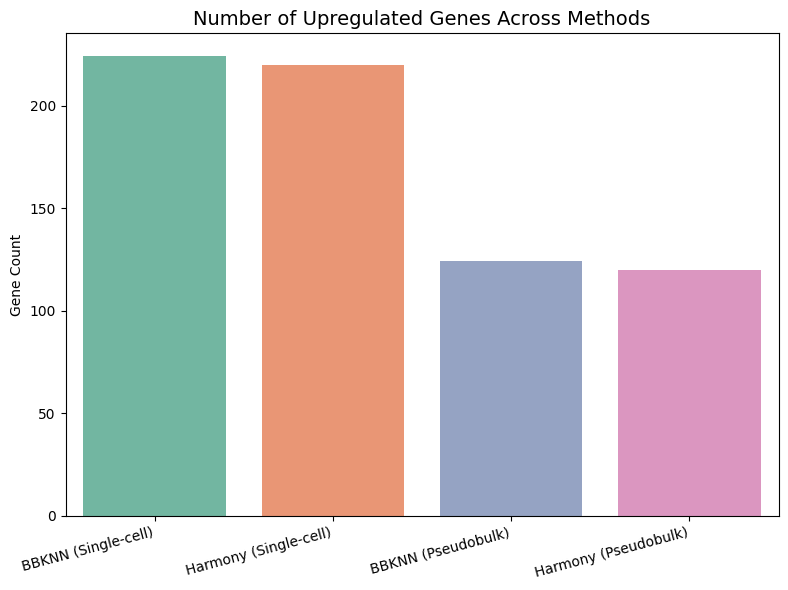

In [66]:
#Task2f: Visualising the 4 lists:

#Preparing gene count data
upreg_counts = pd.DataFrame({
    "Method": [
        "BBKNN (Single-cell)",
        "Harmony (Single-cell)",
        "BBKNN (Pseudobulk)",
        "Harmony (Pseudobulk)"
    ],
    "Upregulated Genes": [
        len(up_genes_bb),   # single-cell BBKNN
        len(up_genes_hm),   # single-cell Harmony
        len(up_bk),         # pseudobulk BBKNN
        len(up_hm)          # pseudobulk Harmony
    ]
})

#Plotting
plt.figure(figsize=(8, 6))
sns.barplot(data=upreg_counts, x="Method", y="Upregulated Genes", palette="Set2")

plt.title("Number of Upregulated Genes Across Methods", fontsize=14)
plt.ylabel("Gene Count")
plt.xlabel("")
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig("Upregulated_Genes_BarPlot.png", dpi=300)
plt.show()

Computing PAGA...
PAGA keys: dict_keys(['connectivities', 'connectivities_tree', 'groups', 'pos'])
Identifying Ms4a1-enriched cluster...
Ms4a1-enriched cluster: 1
Computing UMAP and PHATE...
Visualizing PAGA results...


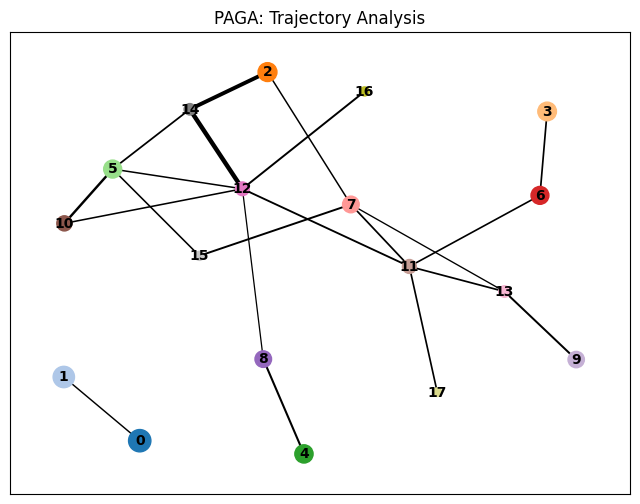

Visualizing PAGA trajectory on UMAP...


/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


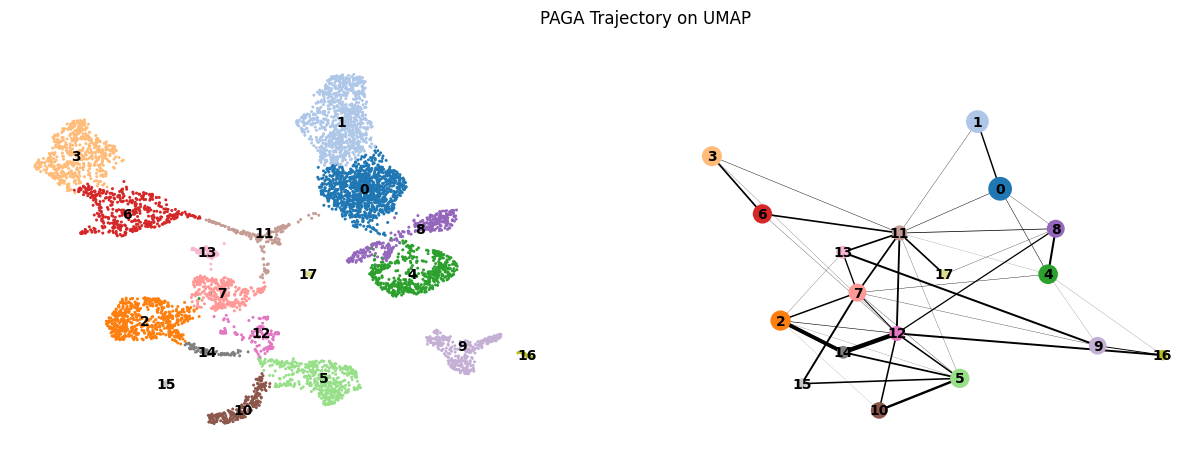

Visualizing PAGA trajectory on PHATE...


/home1/bioinfo-36/scanpy-paga-final/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


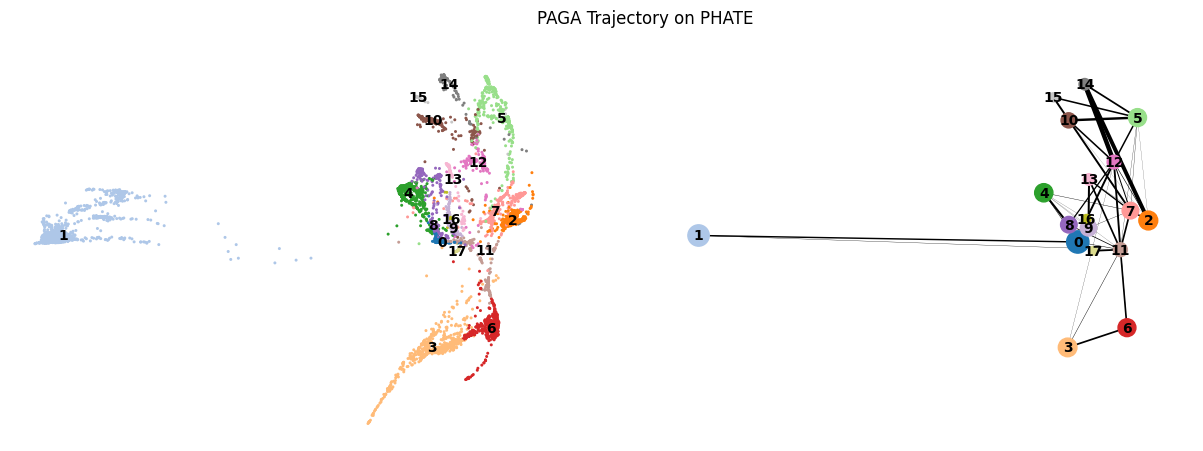

<Figure size 640x480 with 0 Axes>


Misc:
Cluster sizes:
0     1133
1      949
2      578
3      550
4      505
5      477
6      467
7      350
8      344
9      326
10     240
11     171
12     160
13      82
14      78
15      32
16      31
17      25
Name: leiden_Harmony, dtype: int64


In [68]:
#Task 3: Trajectory analysis using PAGA and projecting onto PHATE and UMAP:

#Cleaning the numeric data
adata_harmony.X = np.nan_to_num(adata_harmony.X.copy(), nan=0, posinf=0, neginf=0)

#Computing PAGA connectivity
print("Computing PAGA...")
sc.tl.paga(adata_harmony, groups='leiden_Harmony')

#Ensuring PAGA has been computed correctly
print("PAGA keys:", adata_harmony.uns['paga'].keys()) 

#Identifying the cluster with highest Ms4a1 expression:
print("Identifying Ms4a1-enriched cluster...")
ms4a1_expr = adata_harmony[:, 'Ms4a1'].X.toarray().flatten()  # Ms4a1 expression across all cells
ms4a1_cluster = adata_harmony.obs['leiden_Harmony'][ms4a1_expr > np.percentile(ms4a1_expr, 90)].mode()[0]
print(f"Ms4a1-enriched cluster: {ms4a1_cluster}")

#Creating a custom color palette to handle the nos of colors error
n_clusters = len(adata_harmony.obs['leiden_Harmony'].cat.categories)
palette = [to_hex(c) for c in sns.color_palette('tab20', n_colors=n_clusters)]
adata_harmony.uns['leiden_Harmony_colors'] = palette

#Computing UMAP and PHATE embeddings for visualization
print("Computing UMAP and PHATE...")
sc.tl.umap(adata_harmony, random_state=42)

#Computing Phate
sce.tl.phate(adata_harmony, n_components=2, random_state=42)

#Visualizing the PAGA trajectory plot
print("Visualizing PAGA results...")
fig, ax = plt.subplots(figsize=(8, 6))
sc.pl.paga(
    adata_harmony,
    color='leiden_Harmony',
    threshold=0.1, #Controlling number of edges
    ax=ax,
    show=True,
    title="PAGA: Trajectory Analysis"
)

#Visualizing the trajectory with PAGA and UMAP
print("Visualizing PAGA trajectory on UMAP...")
sc.pl.paga_compare(
    adata_harmony,
    basis='umap',
    show=True,
    title='PAGA Trajectory on UMAP'
)

#Visualizing the trajectory with PAGA and PHATE
print("Visualizing PAGA trajectory on PHATE...")
sc.pl.paga_compare(
    adata_harmony,
    basis='phate',
    show=True,
    title='PAGA Trajectory on PHATE'
)

plt.tight_layout()
plt.show()

#Printing diagnostics
print("\nMisc:")
print("Cluster sizes:")
print(adata_harmony.obs['leiden_Harmony'].value_counts().sort_index())
